# Training an Agent to play the game of Pong

#### Import necessary dependencies

In [16]:
import numpy as np
import gym

from neon.backends import gen_backend
from neon.backends import Autodiff
import random
import os

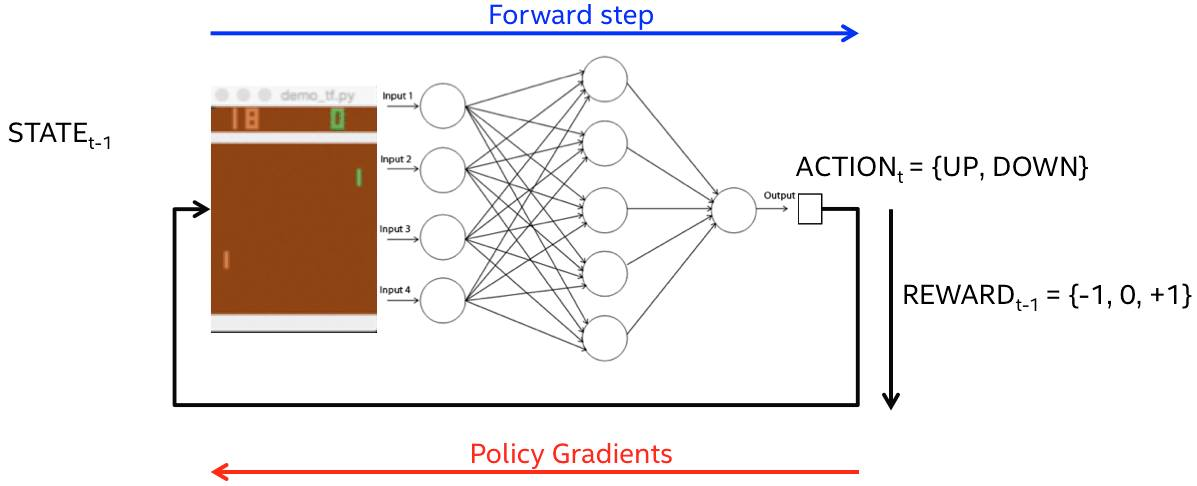

In [17]:
from IPython.display import Image
Image(filename='pong_architecture.jpg')

In [18]:
be = gen_backend('cpu', batch_size = 128)
class Network:
    def __init__(self, D=80*80, H = 200, gamma = 0.99, restore_model = False):
        """
        D: No. of Image pixels
        H: No. of hidden units in first layer of Neural Network
        gamma: discount factor
        """
        self.gamma = gamma
        self.ll = {}
        self.learning_rate = 0.00001
        
        if restore_model and os.path.exists('model_weights.npy'):
            self.ll['W1'] = np.load('model_weights.npy').item()['W1']
            self.ll['W2'] = np.load('model_weights.npy').item()['W2']
        else:
            self.ll['W1'] = be.array(np.random.randn(H,D) / np.sqrt(D)) #random initialization of weight parameters followed by scaling
            self.ll['W2'] = be.array(np.random.randn(H,1) / np.sqrt(H))
        self.dW1 = be.array(np.zeros((H,D))) #random initialization of gradients
        self.dW2 = be.array(np.zeros((H,1)))
    
            
    #forward Propagation
    def policy_forward(self, x):
        # map visual input to the first hidden layer of a neural network
        
        h = be.dot(self.ll['W1'], be.array(x))
        h = be.sig(h)
        dlogp = be.dot(h.transpose(), self.ll['W2'])
        
        p = be.sig(dlogp)
        
        p_val = be.empty((1,1)) # Initialize an empty tensor of size 1X1
        h_val = be.empty((200,1))
        p_val[:] = p # Set values of the tensor to p
        h_val[:] = h
        return p_val.get(), h_val.get(), p, h
    
    #backward propagation
    def policy_backward(self, losses_op, episode_dlogps, episode_rewards):
        
        discounted_rewards = self.discount_rewards(episode_rewards)
        
        # to reduce the variance of the gradient estimator and avoid potential vanishing problems
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        
        episode_dlogps *= discounted_rewards # Modulating gradients with discount factor 
        
        """
        Compute gradients using Neon Backend
        """
        for i in range(len(losses_op)):
            ad = Autodiff(op_tree=losses_op[i]*be.array(episode_dlogps[i]), be = be, next_error=None)
            # compute gradients and assign them to self.dw1 and self.dw2
            ad.back_prop_grad([self.ll['W2'], self.ll['W1']], [self.dW2, self.dW1])
            # weights update:
            self.ll['W2'][:] = self.ll['W2'].get() -self.learning_rate *self.dW2.get()/len(losses_op)
            self.ll['W1'][:] = self.ll['W1'].get() -self.learning_rate *self.dW1.get()/len(losses_op)
        return
    
    def sigmoid(self, x):
        return 1.0/ (1.0 + np.exp(-x))
    
    def get_loss(self, y_fake, up_probability):
        loss = y_fake - up_probability
        return loss
    
    # Reward per time step
    # Reward < 0 if agent missed the ball and hence lost the game
    # Reward > 0 if agent won the game
    # Reward = zero if game in progress
    # The agent receives rewards generated by the game and implements discounted reward backwards with exponential moving average. The agent is rewarded more in the earlier stages 

    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            # if reward at index t is nonzero, then there is a positive/negative reward. This also marks a game boundary
            # for the sequence of game_actions produced by the agent
            if r[t] != 0.0: running_add = 0.0 
            # moving average given discount factor gamma, it assigns more weight to recent game actions
            running_add = running_add * self.gamma + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    # Preprocess a single frame before feeding it to the model
    def prepro(self, I):
        """
        Dimensions of the Image 210x160x3
        We'll downsample the image into a 6400 (80x80) 1D float vector
        """
        I = I[35:195] # crop
        I = I[::2, ::2, 0] # downsaple by a factor of 2
        I[I == 144] = 0 # erase background type 1
        I[I == 109] = 0 # erase background type 2
        I[I!=0] = 1 # Everything else (paddles, ball) equals to 1
        return I.astype(np.float).ravel() # Flattens
    
    # Stochastic process to choose an action ( moving up ) proportional to its predicted probability
    # Probability of choosing the opposite action is (1 - probability_up)
    # action == 2, moving up
    # action == 3, moving down
    def sample_action(self, up_probability):
        stochastic_value = np.random.uniform()
        action = 2 if stochastic_value < up_probability else 3
        return action
    
    

In [19]:
render = False               # to visualize agent 
restore_model = True        # to load a trained model when available

random.seed(2017)

D = 80 * 80                 # number of pixels in input
H = 200                     # number of hidden layer neurons
# Game environment
env = gym.make("Pong-v0")
network = Network(D=D, H=H, restore_model=restore_model)

# Each time step, the agent chooses an action, and the environment returns an observation and a reward.
# The process gets started by calling reset, which returns an initial observation
observation = env.reset()
prev_x = None

# hidden state, gradient ops, gradient values, rewards
hs, losses_op, dlogps, rewards = [],[],[], []
running_reward = None       # current reward
reward_sum = 0.0            # sum rewards
episode_number = 0

game_actions = []
game_rewards = []
game_gradients = []

[2018-01-24 11:43:35,836] Making new env: Pong-v0


### Training process

An action consists of a paddle moving UP/DOWN, which generates a reward +1 (for every win) and -1 for every lost game at the end of each game. 

Before knowing the result of a game, the model gets a fake label via the stochastic process explained before. This is like tossing a coin to decide to accept the log probabilities of a neural network. An optimal set of actions will maximize the sum of rewards along the game. An import event is when the agent wins/losses a game. But what caused this outcome?. The algorithm decided to modulate the loss functions of the network with the positive or negative rewards obtained from the environment and assign more weight to earlier actions using a moving average scheme. This logic is implement in function policy_backward() of the Network class.

In [20]:
while True:
    cur_x = network.prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

    up_probability, h_value, p, h = network.policy_forward(x)
    action = network.sample_action(up_probability)                              

    # assign a fake label, this decreases uncertainty and
    # this is one of the beauties of Reinforcement Learning
    y_fake = 1 if action == 2 else 0     
    
    # loss function gets closer to assigned label, the smaller difference
    # between probabilities the better
    # store gradients: derivative(log(p(x|theta)))       
    dlogp = np.abs(y_fake - up_probability)    
    # loss value
    dlogps.append(dlogp) 
    # loss op
    losses_op.append(be.absolute(y_fake - p))
    
    if render:
        env.render()
    
    #action: 
    #    0: no movement
    #    1: no movement
    #    2: up
    #    3: down
    #    4: up
    #    5: down
    observation, reward, done, info = env.step(action)
    
    # modifying rewards to favor longer games and thus to increase number of
    # positive rewards.
    reward = 0.0 if reward == 0.0 else reward
    reward = 1.0*len(game_rewards) if reward!=0.0 and len(game_rewards)>80 else reward
    reward = -1.0*len(game_rewards) if reward!=0.0 and len(game_rewards)<=50 else reward

    rewards.append(reward)
    reward_sum += reward
    
    game_actions.append(action)
    game_rewards.append(reward)
    game_gradients.append(dlogp[0][0])

    # end of a game
    # Pong has either +1 or -1 as reward when game ends.
    if reward != 0:  
        message = "Episode %d: game finished." % (episode_number)
        if reward < 0:
            message += "\x1b[0;31;40m  (RL loses)\x1b[0m"
        elif reward > 0:
            message += "\x1b[0;32;40m  (RL wins)\x1b[0m"
        print(message)
        print('Game duration: %d steps | Sum rewards: %f | Sum errors: %f' %(len(game_actions), np.sum(game_rewards), np.sum(game_gradients)))
        print('------------------------------------')
        game_actions = []
        game_rewards = []
        game_gradients = []
        
    # to save model
    if (episode_number+1)%10==0:
        np.save('model_weights.npy', network.ll)
        
    # end of an episode (minibatch of games)
    if done:
        episode_number +=1
        dlogps = np.vstack(dlogps)
        rewards = np.vstack(rewards)
        
        network.policy_backward(losses_op, dlogps, rewards)
        mean_loss = np.sum([x * x for x in dlogps])
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('-----------------------------------------------')
        print('Episode %d has finished, time to backpropagate.' % (episode_number - 1))
        print('Total reward was %f Running_reward: %f Mean_loss: %f' % (reward_sum, running_reward, mean_loss))
        print('-----------------------------------------------')

        # reset game environment
        observation = env.reset()  
        reward_sum = 0
        prev_x = None        
        dlogps, rewards = [], []
        losses_op = []

Episode 0: game finished.  (RL wins)
Game duration: 91 steps | Sum rewards: 90.000000 | Sum errors: 45.376827
------------------------------------
Episode 0: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.996187
------------------------------------
Episode 0: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 23.053751
------------------------------------
Episode 0: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.348719
------------------------------------
Episode 0: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.202196
------------------------------------
Episode 0: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.652737
------------------------------------
Episode 0: game finished.  (RL loses)
Game duration: 50 steps | Sum rewards: -49.000000 | Sum errors: 25.071

Episode 2: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.222404
------------------------------------
Episode 2: game finished.  (RL loses)
Game duration: 51 steps | Sum rewards: -50.000000 | Sum errors: 25.595770
------------------------------------
Episode 2: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.552696
------------------------------------
Episode 2: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.311180
------------------------------------
Episode 2: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.464745
------------------------------------
Episode 2: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.826958
------------------------------------
Episode 2: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.4

Episode 4: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.479473
------------------------------------
Episode 4: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.161865
------------------------------------
Episode 4: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.345392
------------------------------------
Episode 4: game finished.  (RL loses)
Game duration: 43 steps | Sum rewards: -42.000000 | Sum errors: 21.423512
------------------------------------
Episode 4: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 22.807337
------------------------------------
Episode 4: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.020432
------------------------------------
Episode 4: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 22.5

-----------------------------------------------
Episode 6 has finished, time to backpropagate.
Total reward was -823.000000 Running_reward: -807.950374 Mean_loss: 248.764359
-----------------------------------------------
Episode 7: game finished.  (RL wins)
Game duration: 87 steps | Sum rewards: 86.000000 | Sum errors: 43.650337
------------------------------------
Episode 7: game finished.  (RL wins)
Game duration: 128 steps | Sum rewards: 127.000000 | Sum errors: 63.959682
------------------------------------
Episode 7: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 23.011723
------------------------------------
Episode 7: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.339840
------------------------------------
Episode 7: game finished.  (RL wins)
Game duration: 86 steps | Sum rewards: 85.000000 | Sum errors: 42.359077
------------------------------------
Episode 7: game finished.  (RL wins)


Episode 9: game finished.  (RL wins)
Game duration: 128 steps | Sum rewards: 127.000000 | Sum errors: 63.455860
------------------------------------
Episode 9: game finished.  (RL wins)
Game duration: 83 steps | Sum rewards: 82.000000 | Sum errors: 41.611740
------------------------------------
Episode 9: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 24.017082
------------------------------------
Episode 9: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 23.177258
------------------------------------
Episode 9: game finished.  (RL wins)
Game duration: 128 steps | Sum rewards: 127.000000 | Sum errors: 63.487244
------------------------------------
Episode 9: game finished.  (RL wins)
Game duration: 130 steps | Sum rewards: 129.000000 | Sum errors: 64.564743
------------------------------------
Episode 9: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.992

Episode 11: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.389635
------------------------------------
Episode 11: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.557888
------------------------------------
Episode 11: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.413317
------------------------------------
Episode 11: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.972313
------------------------------------
Episode 11: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 22.801592
------------------------------------
Episode 11: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.467907
------------------------------------
Episode 11: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum error

Episode 13: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.602791
------------------------------------
Episode 13: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 25.039165
------------------------------------
Episode 13: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.698425
------------------------------------
Episode 13: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 22.736320
------------------------------------
Episode 13: game finished.  (RL loses)
Game duration: 51 steps | Sum rewards: -50.000000 | Sum errors: 25.444212
------------------------------------
Episode 13: game finished.  (RL loses)
Game duration: 44 steps | Sum rewards: -43.000000 | Sum errors: 21.789553
------------------------------------
Episode 13: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum error

Episode 15: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.854671
------------------------------------
Episode 15: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 24.232740
------------------------------------
Episode 15: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 24.126274
------------------------------------
Episode 15: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.015961
------------------------------------
Episode 15: game finished.  (RL loses)
Game duration: 43 steps | Sum rewards: -42.000000 | Sum errors: 21.243877
------------------------------------
-----------------------------------------------
Episode 15 has finished, time to backpropagate.
Total reward was -485.000000 Running_reward: -762.414509 Mean_loss: 298.228760
-----------------------------------------------
Episode 16: game finished. 

-----------------------------------------------
Episode 17 has finished, time to backpropagate.
Total reward was -458.000000 Running_reward: -758.237660 Mean_loss: 303.830200
-----------------------------------------------
Episode 18: game finished.  (RL wins)
Game duration: 179 steps | Sum rewards: 178.000000 | Sum errors: 89.779861
------------------------------------
Episode 18: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.567371
------------------------------------
Episode 18: game finished.  (RL wins)
Game duration: 126 steps | Sum rewards: 125.000000 | Sum errors: 63.381622
------------------------------------
Episode 18: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 23.059711
------------------------------------
Episode 18: game finished.  (RL wins)
Game duration: 289 steps | Sum rewards: 288.000000 | Sum errors: 143.731628
------------------------------------
Episode 18: game finished.

Episode 20: game finished.  (RL wins)
Game duration: 127 steps | Sum rewards: 126.000000 | Sum errors: 63.575485
------------------------------------
Episode 20: game finished.  (RL loses)
Game duration: 41 steps | Sum rewards: -40.000000 | Sum errors: 19.997942
------------------------------------
Episode 20: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 24.061417
------------------------------------
Episode 20: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.734491
------------------------------------
Episode 20: game finished.  (RL loses)
Game duration: 44 steps | Sum rewards: -43.000000 | Sum errors: 21.724445
------------------------------------
Episode 20: game finished.  (RL wins)
Game duration: 126 steps | Sum rewards: 125.000000 | Sum errors: 62.302235
------------------------------------
Episode 20: game finished.  (RL loses)
Game duration: 50 steps | Sum rewards: -49.000000 | Sum error

Episode 22: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.276249
------------------------------------
Episode 22: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.556034
------------------------------------
Episode 22: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.849798
------------------------------------
Episode 22: game finished.  (RL loses)
Game duration: 50 steps | Sum rewards: -49.000000 | Sum errors: 24.934359
------------------------------------
Episode 22: game finished.  (RL loses)
Game duration: 44 steps | Sum rewards: -43.000000 | Sum errors: 21.800476
------------------------------------
Episode 22: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 23.198492
------------------------------------
Episode 22: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum error

Episode 24: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 24.213699
------------------------------------
Episode 24: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.265503
------------------------------------
Episode 24: game finished.  (RL loses)
Game duration: 43 steps | Sum rewards: -42.000000 | Sum errors: 21.419636
------------------------------------
Episode 24: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.408100
------------------------------------
-----------------------------------------------
Episode 24 has finished, time to backpropagate.
Total reward was -917.000000 Running_reward: -729.164724 Mean_loss: 253.968063
-----------------------------------------------
Episode 25: game finished.  (RL wins)
Game duration: 87 steps | Sum rewards: 86.000000 | Sum errors: 43.004387
------------------------------------
Episode 25: game finished.  (

Episode 27: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 22.953470
------------------------------------
Episode 27: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.955006
------------------------------------
Episode 27: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.926533
------------------------------------
Episode 27: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.580868
------------------------------------
Episode 27: game finished.  (RL loses)
Game duration: 43 steps | Sum rewards: -42.000000 | Sum errors: 21.408205
------------------------------------
Episode 27: game finished.  (RL loses)
Game duration: 51 steps | Sum rewards: -50.000000 | Sum errors: 25.238276
------------------------------------
Episode 27: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum error

Episode 29: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.166044
------------------------------------
Episode 29: game finished.  (RL loses)
Game duration: 51 steps | Sum rewards: -50.000000 | Sum errors: 25.356886
------------------------------------
Episode 29: game finished.  (RL loses)
Game duration: 44 steps | Sum rewards: -43.000000 | Sum errors: 21.665936
------------------------------------
Episode 29: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.390562
------------------------------------
Episode 29: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.091024
------------------------------------
Episode 29: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.088116
------------------------------------
Episode 29: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum error

Episode 31: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.342823
------------------------------------
Episode 31: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.292297
------------------------------------
Episode 31: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 22.849842
------------------------------------
Episode 31: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.529652
------------------------------------
Episode 31: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 22.883749
------------------------------------
Episode 31: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.406586
------------------------------------
Episode 31: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum error

Episode 33: game finished.  (RL wins)
Game duration: 85 steps | Sum rewards: 84.000000 | Sum errors: 42.166908
------------------------------------
Episode 33: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 24.276091
------------------------------------
Episode 33: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.477402
------------------------------------
-----------------------------------------------
Episode 33 has finished, time to backpropagate.
Total reward was -178.000000 Running_reward: -710.825876 Mean_loss: 345.620697
-----------------------------------------------
Episode 34: game finished.  (RL wins)
Game duration: 86 steps | Sum rewards: 85.000000 | Sum errors: 42.931141
------------------------------------
Episode 34: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.767426
------------------------------------
Episode 34: game finished.  (RL

Episode 36: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.297388
------------------------------------
Episode 36: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.926521
------------------------------------
Episode 36: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum errors: 23.508629
------------------------------------
Episode 36: game finished.  (RL loses)
Game duration: 47 steps | Sum rewards: -46.000000 | Sum errors: 23.423769
------------------------------------
Episode 36: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.072962
------------------------------------
Episode 36: game finished.  (RL loses)
Game duration: 44 steps | Sum rewards: -43.000000 | Sum errors: 21.898241
------------------------------------
Episode 36: game finished.  (RL loses)
Game duration: 48 steps | Sum rewards: -47.000000 | Sum error

Episode 38: game finished.  (RL wins)
Game duration: 126 steps | Sum rewards: 125.000000 | Sum errors: 62.637062
------------------------------------
Episode 38: game finished.  (RL loses)
Game duration: 46 steps | Sum rewards: -45.000000 | Sum errors: 23.160406
------------------------------------
Episode 38: game finished.  (RL loses)
Game duration: 50 steps | Sum rewards: -49.000000 | Sum errors: 24.979136
------------------------------------
Episode 38: game finished.  (RL loses)
Game duration: 45 steps | Sum rewards: -44.000000 | Sum errors: 22.413969
------------------------------------
Episode 38: game finished.  (RL loses)
Game duration: 44 steps | Sum rewards: -43.000000 | Sum errors: 21.979652
------------------------------------
Episode 38: game finished.  (RL loses)
Game duration: 49 steps | Sum rewards: -48.000000 | Sum errors: 24.268328
------------------------------------
Episode 38: game finished.  (RL wins)
Game duration: 133 steps | Sum rewards: 132.000000 | Sum error

KeyboardInterrupt: 